# Introduction to deep learning for computer vision

## Introduction to convnets

**Instantiating a small convnet**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

**Displaying the model's summary**

Explain the model architecture:


* The convnet to process inputs of size (28, 28, 1), work with greyscale images
* The output of every Conv2D and MaxPooling2D layer is a rank-3 tensor of shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the model. The number of channels is controlled by the first argument passed to the Conv2D layers (32, 64, or 128).
* After the last Conv2D layer, we end up with an output of shape (3, 3, 128)—a 3 × 3 feature map of 128 channels.
* The next step is to feed this output into a densely connected classifier like those you’re already familiar with: a stack of Dense layers. These classifiers process vectors, which are 1D, whereas the current output is a rank-3 tensor.
* To bridge the gap, we flatten the 3D outputs to 1D with a Flatten layer before adding the Dense layers.
* Finally, we do 10-way classification, so our last layer has 10 outputs and a softmax activation.

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856 

**Training the convnet on MNIST images**

In [ ]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype("float32") / 255
model.compile(optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

11490434/11490434 [==============================] - 0s 0us/step
Epoch 1/5
938/938 [==============================] - 7s 4ms/step - loss: 0.1599 - accuracy: 0.9487
Epoch 2/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0423 - accuracy: 0.9867
Epoch 3/5
938/938 [==============================] - 3s 4ms/step - loss: 0.0298 - accuracy: 0.9911
Epoch 4/5
938/938 [==============================] - 3s 4ms/step - loss: 0.0232 - accuracy: 0.9929
Epoch 5/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0178 - accuracy: 0.9944


**Evaluating the convnet**

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

313/313 [==============================] - 1s 3ms/step - loss: 0.0223 - accuracy: 0.9931
Test accuracy: 0.993


### The max-pooling operation

**An incorrectly structured convnet missing its max-pooling layers**

In [ ]:
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model_no_max_pool = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model_no_max_pool.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 22, 22, 128)       73856     
                                                                 
 flatten_1 (Flatten)         (None, 61952)             0         
                                                                 
 dense_1 (Dense)             (None, 10)                619530    
                                                                 
Total params: 712202 (2.72 MB)
Trainable params: 712202 (2.

## Training a convnet from scratch on a small dataset

Classifying images as dogs or cats in a dataset containing 5,000 pictures of cats and dogs (2,500 cats, 2,500 dogs).

Use 2,000 pictures for training, 1,000 for validation, and 2,000 for testing.

### Downloading the data

In order to use the dataset, create Kaggle API, download and upload to the file upload to use data in your own machine

In [ ]:
from google.colab import files
files.upload()

Create a ~/.kaggle folder **(mkdir ~/.kaggle)**,

and copy the key file to it **(cp kaggle.json ~/.kaggle/)**.

As a security best practice, make sure that the file is only readable by the current user, yourself **(chmod 600)**

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c dogs-vs-cats

 98% 795M/812M [00:08<00:00, 177MB/s]
100% 812M/812M [00:08<00:00, 104MB/s]


In [ ]:
!unzip -qq dogs-vs-cats.zip

In [ ]:
!unzip -qq train.zip

This dataset contains 25,000 images of dogs and cats (12,500 from each class) and is 543 MB (compressed).

After downloading and uncompressing the data, create a new dataset containing three subsets:
* a training set with 1,000 samples of each class, *(train/cat-1000, dog-1000)*
* a validation set with 500 samples of each class, *(validation/cat-500, dog-500)*
* a test set with 1,000 samples of each class. *(test/cat-1000, dog-1000)*

**Copying images to training, validation, and test directories**

Create a function to copy image:

Utility function to **copy cat (and dog) images** from index **start_index** to index **end_index** to the subdirectory **new_base_dir/{subset_name}/cat (and /dog)**.

The "subset_name" will be either "**train**", "**validation**", or "**test**".

In [ ]:
import os, shutil, pathlib

# Path to the directory where the original dataset was uncompressed
original_dir = pathlib.Path("train")
# Directory where we will store our smaller dataset
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

# Create the training subset with the first 1,000 images of each category
make_subset("train", start_index=0, end_index=1000)
# Create the validation subset with the next 500 images of each category
make_subset("validation", start_index=1000, end_index=1500)
# Create the test subset with the next 1,000 images of each category
make_subset("test", start_index=1500, end_index=2500)

### Building the model

Model architecture:
* Start from inputs of size 180 pixels × 180 pixels
* Then start the model with a Rescaling layer, which will rescale image inputs (whose values are originally in the [0, 255] range) to the [0, 1] range.
* Stack of alternated Conv2D (with relu activation) and MaxPooling2D layers (x3)
* Make model larger by adding two more Conv2D and MaxPooling2D stages. This serves both to augment the capacity of the model and to further reduce the size of the feature maps so they aren’t overly large when we reach the Flatten layer
* Because we start from inputs of size 180 pixels × 180 pixels (a somewhat arbitrary choice), we end up with feature maps of size 7 × 7 just before the Flatten layer

**Instantiating a small convnet for dogs vs. cats classification**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# The model expects RGB images of size 180*180
inputs = keras.Input(shape=(180, 180, 3))
# Rescale inputs to the [0, 1] range by dividing them by 255
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
# A Dense layer of size 1 and a sigmoid activation since it's binary-classification problem
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                      

**Configuring the model for training**

For the compilation step, we’ll go with the RMSprop optimizer, as usual.

Because we ended the model with a single sigmoid unit, we’ll use binary crossentropy as the loss

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

### Data preprocessing

**Using image_dataset_from_directory to read images**

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

# 32 samples in each batch (the batch size)
# RGB images (shape (32, 180, 180, 3))

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


**Displaying the shapes of the data and labels yielded by the Dataset**

In [ ]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


**Fitting the model using a Dataset**

Use a ModelCheckpoint callback to save the model after each epoch
* filepath - specifying where to save the file
* save_best_only - saved file will always contain the state of the model corresponding to its bestperforming training epoch, in terms of its performance on the validation data

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 10s 102ms/step - loss: 0.7044 - accuracy: 0.5060 - val_loss: 0.6890 - val_accuracy: 0.6160
Epoch 2/30
63/63 [==============================] - 6s 81ms/step - loss: 0.6956 - accuracy: 0.5300 - val_loss: 0.6722 - val_accuracy: 0.6040
Epoch 3/30
63/63 [==============================] - 4s 55ms/step - loss: 0.6736 - accuracy: 0.5945 - val_loss: 0.8858 - val_accuracy: 0.5000
Epoch 4/30
63/63 [==============================] - 10s 151ms/step - loss: 0.6673 - accuracy: 0.6225 - val_loss: 0.6578 - val_accuracy: 0.5900
Epoch 5/30
63/63 [==============================] - 4s 63ms/step - loss: 0.6285 - accuracy: 0.6565 - val_loss: 0.6548 - val_accuracy: 0.6160
Epoch 6/30
63/63 [==============================] - 4s 57ms/step - loss: 0.6056 - accuracy: 0.6780 - val_loss: 0.8491 - val_accuracy: 0.5330
Epoch 7/30
63/63 [==============================] - 5s 80ms/step - loss: 0.5903 - accuracy: 0.6825 - val_loss: 0.7280 - val_accuracy: 0.6230
Epoch 8/3

**Displaying curves of loss and accuracy during training**

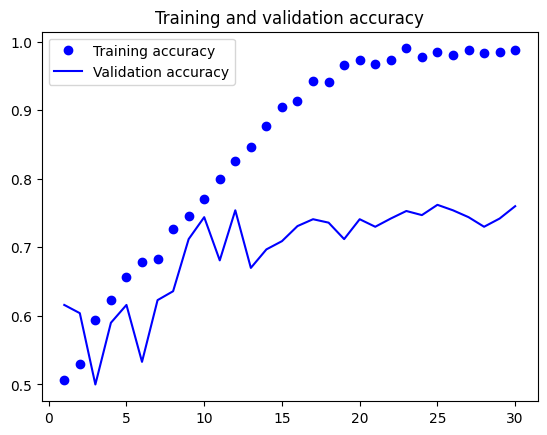

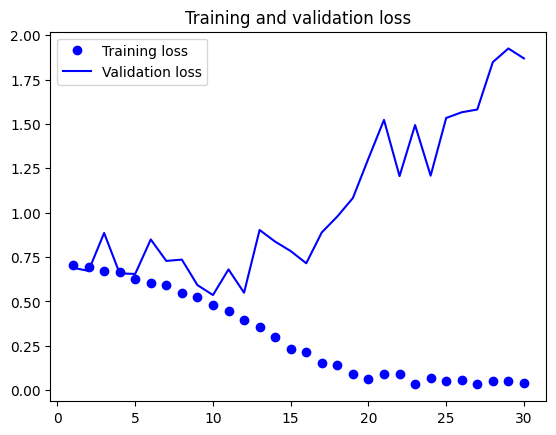

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

These plots are characteristic of overfitting. The training accuracy increases linearly over time, until it reaches nearly 100%, whereas the validation accuracy peaks at 76%.

The validation loss reaches its minimum after only ten epochs and then stalls, whereas the training loss keeps decreasing linearly as training proceeds.

**Evaluating the model on the test set**

After training the model, we evaluate the model and get the test accuracy of 73%.

In the next training, we'll do data augmentation, modify traing model and retrain the model with augmented dataset

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 2s 30ms/step - loss: 0.5459 - accuracy: 0.7300
Test accuracy: 0.730


### Using data augmentation

**Define a data augmentation stage to add to an image model**

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

**Displaying some randomly augmented training images**

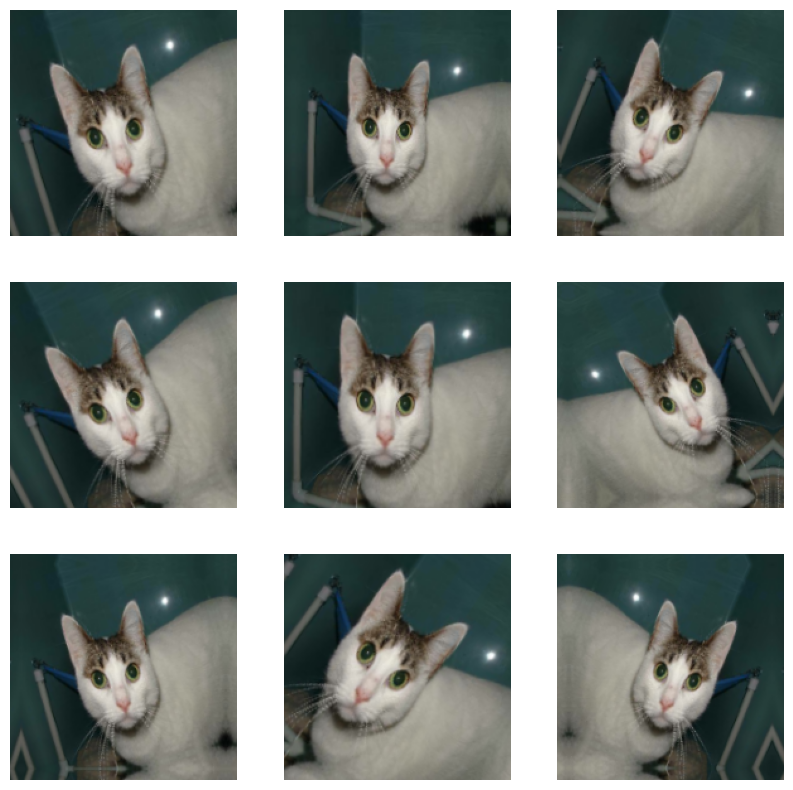

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

**Defining a new convnet that includes image augmentation and dropout**

In [ ]:
# Add data_augmentation layer
# Add Dropout layer before densely connected classifier

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

**Training the regularized convnet**

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 4s 61ms/step - loss: 0.3521 - accuracy: 0.8390 - val_loss: 0.6049 - val_accuracy: 0.7670
Epoch 2/100
63/63 [==============================] - 5s 74ms/step - loss: 0.3593 - accuracy: 0.8390 - val_loss: 0.4707 - val_accuracy: 0.7940
Epoch 3/100
63/63 [==============================] - 6s 87ms/step - loss: 0.3215 - accuracy: 0.8645 - val_loss: 0.5183 - val_accuracy: 0.7940
Epoch 4/100
63/63 [==============================] - 4s 59ms/step - loss: 0.3394 - accuracy: 0.8475 - val_loss: 0.4397 - val_accuracy: 0.8180
Epoch 5/100
63/63 [==============================] - 4s 59ms/step - loss: 0.3141 - accuracy: 0.8695 - val_loss: 0.4424 - val_accuracy: 0.8220
Epoch 6/100
63/63 [==============================] - 7s 100ms/step - loss: 0.3287 - accuracy: 0.8590 - val_loss: 0.4336 - val_accuracy: 0.8080
Epoch 7/100
63/63 [==============================] - 4s 60ms/step - loss: 0.3220 - accuracy: 0.8585 - val_loss: 0.4686 - val_accuracy: 0.8020
Epoch

**Evaluating the model on the test set**

In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 2s 31ms/step - loss: 0.4422 - accuracy: 0.8195
Test accuracy: 0.820


## Leveraging a pretrained model

### Feature extraction with a pretrained model

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

# weights - specifies the weight checkpoint from which to initialize the model.
# include_top - refers to including (or not) the densely connected classifier on top of the network.
# input_shape - is the shape of the image tensors that we’ll feed to the network.

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [ ]:
# Extracting the VGG16 features and corresponding labels

# preprocessed_images = keras.applications.vgg16.preprocess_input(images) - scales pixel values to an appropriate range.

import numpy as np

def get_features_and_labels(dataset):
  all_features = []
  all_labels = []
  for images, labels in dataset:
    preprocessed_images = keras.applications.vgg16.preprocess_input(images)
    features = conv_base.predict(preprocessed_images)
    all_features.append(features)
    all_labels.append(labels)
  return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 31ms/step


In [ ]:
train_features.shape
# (samples, 5, 5, 512)

(2000, 5, 5, 512)

**Defining and training the densely connected classifier**

In [ ]:
# Model without data augmentation

inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

# Note the use of the Flatten layer before passing the features to a Dense layer.

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction.keras",
        save_best_only=True,
        monitor="val_loss")
]

In [ ]:
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 1s 14ms/step - loss: 14.6359 - accuracy: 0.9280 - val_loss: 10.5043 - val_accuracy: 0.9430
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 4.4419 - accuracy: 0.9735 - val_loss: 4.5597 - val_accuracy: 0.9660
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 2.4244 - accuracy: 0.9845 - val_loss: 4.2963 - val_accuracy: 0.9750
Epoch 4/20
63/63 [==============================] - 0s 8ms/step - loss: 1.2933 - accuracy: 0.9905 - val_loss: 5.6763 - val_accuracy: 0.9710
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 0.6772 - accuracy: 0.9945 - val_loss: 9.0271 - val_accuracy: 0.9660
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 1.1101 - accuracy: 0.9920 - val_loss: 4.3170 - val_accuracy: 0.9770
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 0.9043 - accuracy: 0.9945 - val_loss: 3.7963 - val_accuracy: 0.9740
Epoch 8/20
63/63 

In [ ]:
history.history

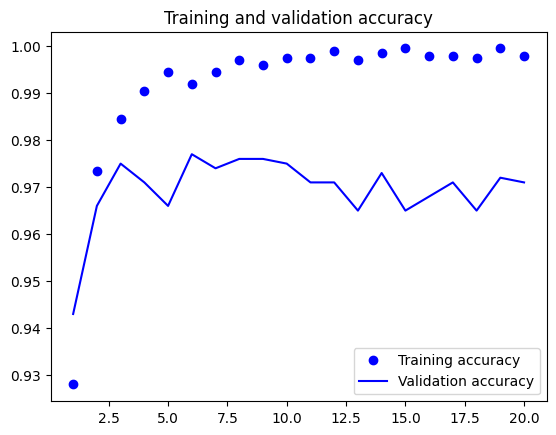

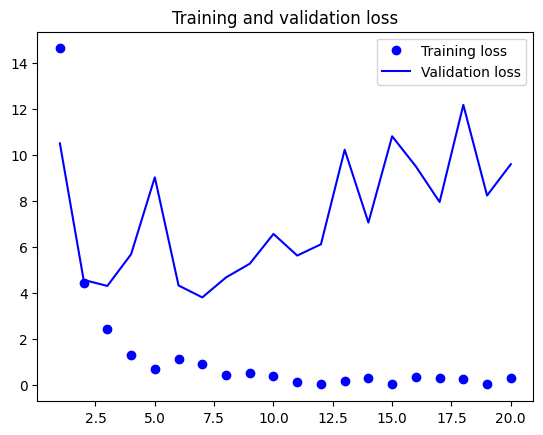

In [ ]:
# Plotting the results
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

The training seems overfitting since the begining of the training even if we reach a validation accuracy of about 97%.

We'll apply data augmentation, which is essential for preventing overfitting with small image datasets.

**FEATURE EXTRACTION TOGETHER WITH DATA AUGMENTATION**

Creating a model that **chains the conv_base** with **a new dense classifier**, and **training it end to end on the inputs**.

In order to do this, we will first freeze the convolutional base. **Freezing a layer or set of layers means preventing their weights from being updated during training**.

If we don’t do this, the representations that were previously learned by the convolutional base will be modified during training.

Because the Dense layers on top are randomly initialized, very large weight updates would be propagated through the network, effectively destroying the representations previously learned.

**In Keras, we freeze a layer or model by setting its trainable attribute to False.**

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

conv_base.trainable = False

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
# Printing the list of trainable weights before and after freezing
conv_base.trainable = True
print("This is the number of trainable weights before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [ ]:
conv_base.trainable = False
print("This is the number of trainable weights after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


Create a new model that chains together:
* Add data augmentation layer
* Add frozen convolutional base
* Add dense classifier

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

**Modify the model**

In [ ]:
import tensorflow as tf

In [ ]:
# solution from stackoverflow
# This can be used instead of keras.applications.vgg16.preprocess_input,
# it does the same transform but can be serialized successfully
def preprocess_input(imgs):
    return tf.reverse(imgs, axis=[-1]) - tf.constant([103.939, 116.779, 123.68], dtype=tf.float32)

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs) # Apply data augmentation
x = preprocess_input(x) # Apply input value scaling after augmenting data
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 tf.reverse_1 (TFOpLambda)   (None, 180, 180, 3)       0         
                                                                 
 tf.math.subtract_1 (TFOpLa  (None, 180, 180, 3)       0         
 mbda)                                                           
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_8 (Flatten)         (None, 12800)             0         
                                                           

In [ ]:
callbacks = [
  keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction_with_data_augmentation.keras",
    save_best_only=True,
    monitor="val_loss")
]

In [ ]:
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 14s 195ms/step - loss: 17.8852 - accuracy: 0.8985 - val_loss: 3.1292 - val_accuracy: 0.9740
Epoch 2/50
63/63 [==============================] - 10s 156ms/step - loss: 7.5124 - accuracy: 0.9435 - val_loss: 4.4651 - val_accuracy: 0.9660
Epoch 3/50
63/63 [==============================] - 12s 183ms/step - loss: 5.4048 - accuracy: 0.9575 - val_loss: 4.3981 - val_accuracy: 0.9750
Epoch 4/50
63/63 [==============================] - 10s 153ms/step - loss: 4.6805 - accuracy: 0.9600 - val_loss: 10.2113 - val_accuracy: 0.9560
Epoch 5/50
63/63 [==============================] - 10s 157ms/step - loss: 5.1284 - accuracy: 0.9625 - val_loss: 4.6732 - val_accuracy: 0.9770
Epoch 6/50
63/63 [==============================] - 12s 181ms/step - loss: 3.8544 - accuracy: 0.9635 - val_loss: 3.7539 - val_accuracy: 0.9810
Epoch 7/50
63/63 [==============================] - 10s 151ms/step - loss: 2.9373 - accuracy: 0.9730 - val_loss: 3.5921 - val_accuracy: 0.97

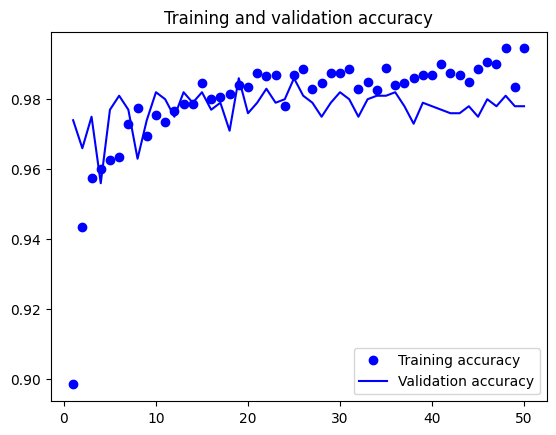

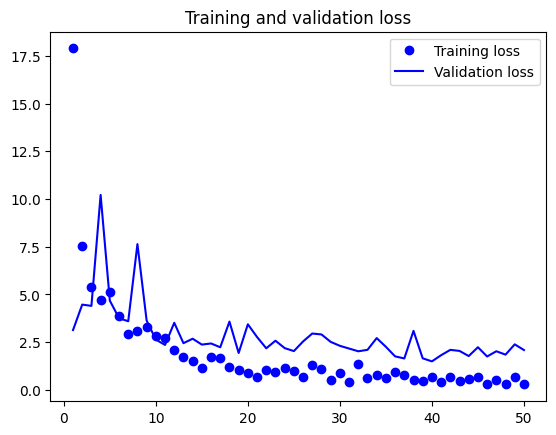

In [ ]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Evaluating the model on the test set**

In [ ]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 7s 93ms/step - loss: 1.9147 - accuracy: 0.9765
Test accuracy: 0.976


We get a test accuracy of 97.6%, which is a modest improvement compared to the previous test acuuracy.

### Fine-tuning a pretrained model

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

# weights - specifies the weight checkpoint from which to initialize the model.
# include_top - refers to including (or not) the densely connected classifier on top of the network.
# input_shape - is the shape of the image tensors that we’ll feed to the network.

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

**Freezing all layers until the fourth from the last**

Earlier layers in the convolutional base encode more generic, reusable features,

whereas **layers higher up encode more specialized features**

In [ ]:
# Freeze all the layers and take only the last 4 layers for training

conv_base.trainable = True
for layer in conv_base.layers[:-4]:
  layer.trainable = False

**Fine-tuning the model**

* The reason for using a low learning rate is that we want to limit the magnitude of the modifications we make to the representations of the three layers we’re fine-tuning.

* Updates that are too large may harm these representations.

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]

In [ ]:
history = model.fit(train_dataset,
                    epochs=30,
                    validation_data=validation_dataset,
                    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 11s 147ms/step - loss: 6.3066 - accuracy: 0.6975 - val_loss: 1.5489 - val_accuracy: 0.9090
Epoch 2/30
63/63 [==============================] - 10s 152ms/step - loss: 2.9568 - accuracy: 0.8375 - val_loss: 1.1261 - val_accuracy: 0.9370
Epoch 3/30
63/63 [==============================] - 10s 150ms/step - loss: 1.9943 - accuracy: 0.8765 - val_loss: 0.9005 - val_accuracy: 0.9490
Epoch 4/30
63/63 [==============================] - 10s 151ms/step - loss: 1.5753 - accuracy: 0.9105 - val_loss: 0.8003 - val_accuracy: 0.9560
Epoch 5/30
63/63 [==============================] - 10s 157ms/step - loss: 1.4158 - accuracy: 0.9000 - val_loss: 0.6353 - val_accuracy: 0.9640
Epoch 6/30
63/63 [==============================] - 12s 186ms/step - loss: 1.3619 - accuracy: 0.9215 - val_loss: 0.5939 - val_accuracy: 0.9650
Epoch 7/30
63/63 [==============================] - 10s 162ms/step - loss: 1.0624 - accuracy: 0.9350 - val_loss: 0.5701 - val_accuracy: 0.9680

**Evaluate this model on the test data**

In [ ]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 7s 97ms/step - loss: 0.4783 - accuracy: 0.9715
Test accuracy: 0.971


Here, we get a test accuracy of 97.1%